In [1]:
# This notebook performs data quality checks, displays querying data and Visualizations from Crypto Data Warehouse tables

In [2]:
import configparser
import numpy as np
import psycopg2
import boto3
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import text
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
config = configparser.ConfigParser()
config.read_file(open('api.cfg'))

In [4]:
# Loading AWS Configurations
KEY = config.get('AWS', 'ACCESS KEY')
SECRET = config.get('AWS', 'ACCESS SECRET')

# Loading DWH Configurations
DWH_CLUSTER_TYPE = config.get("DWH", "DWH_CLUSTER_TYPE")
DWH_NUM_NODES = config.get("DWH", "DWH_NUM_NODES")
DWH_NODE_TYPE = config.get("DWH", "DWH_NODE_TYPE")
DWH_CLUSTER_IDENTIFIER = config.get("DWH", "DWH_CLUSTER_IDENTIFIER")
DWH_DB = config.get("DWH", "DWH_DB")
DWH_DB_USER = config.get("DWH", "DWH_DB_USER")
DWH_DB_PASSWORD = config.get("DWH", "DWH_DB_PASSWORD")
DWH_PORT = config.get("DWH", "DWH_PORT")
DWH_IAM_ROLE_NAME = config.get("DWH", "DWH_IAM_ROLE_NAME")

# Connecting to AWS resources
redshift = boto3.client('redshift',
                        region_name='us-west-2',
                        aws_access_key_id=KEY,
                        aws_secret_access_key=SECRET
                        )

iam = boto3.client('iam',
                   region_name='us-west-2',
                   aws_access_key_id=KEY,
                   aws_secret_access_key=SECRET
                   )

roleArn = iam.get_role(RoleName=DWH_IAM_ROLE_NAME)['Role']['Arn']
myClusterProps = redshift.describe_clusters(ClusterIdentifier=DWH_CLUSTER_IDENTIFIER)['Clusters'][0]

DWH_ENDPOINT = myClusterProps['Endpoint']['Address']
DWH_ROLE_ARN = myClusterProps['IamRoles'][0]['IamRoleArn']

In [5]:
# Opening Connection to PostgresSQL Server in AWS
conn_string="postgresql://{}:{}@{}:{}/{}".format(DWH_DB_USER, DWH_DB_PASSWORD, DWH_ENDPOINT, DWH_PORT,DWH_DB)
engine = create_engine(conn_string)

## Data Quality Checks

In [6]:
data_quality_checks = [["SELECT COUNT(*) FROM crypto_latest_info_fact_table", 0], 
                       ["SELECT COUNT(*) FROM cryptocurrency_top_100", 0],
                       ["SELECT COUNT(*) FROM crypto_historical_info_fact_table", 0],
                       ["SELECT COUNT(*) FROM crypto_price_timestamp", 0],
                       ["SELECT COUNT(*) FROM bitcoin_historical_price", 0],
                       ["SELECT COUNT(*) FROM crypto_tweet_fact_table", 0],
                       ["SELECT COUNT(*) FROM crypto_tweet_users", 0],
                       ["SELECT COUNT(*) FROM user_sentiment", 0]]
                       
for quality_check, res in data_quality_checks:
    df = pd.read_sql_query(text(f"{quality_check}"), engine)
    if df.shape[0] == res or df.shape[1] == res:
        print("Data Quality Check Failed. Table is Empty.")
    else:
        print("Data Quality Check Passed!")

Data Quality Check Passed!
Data Quality Check Passed!
Data Quality Check Passed!
Data Quality Check Passed!
Data Quality Check Passed!
Data Quality Check Passed!
Data Quality Check Passed!
Data Quality Check Passed!


## Data Analysis

In [7]:
# Querying Crypto Latest Info Fact Table
crypto_latest_info_df = pd.read_sql_query(text("SELECT crypto_id, name, circulating_supply, cmc_rank, curr_price \
                                               FROM crypto_latest_info_fact_table WHERE curr_price >= 100"), engine)
crypto_latest_info_df.head(20)

,crypto_id,name,circulating_supply,cmc_rank,curr_price
0,10608,Sake,0.0,4635,22753.0
1,11415,Yield Yak,0.0,3285,5208.0
2,12035,Data Economy Index,0.0,4426,109.0
3,12827,ScareCrow,0.0,2851,397.0
4,13642,Exodia,0.0,2943,6787.0
5,12903,Staked Olympus,0.0,3247,1089.0
6,2,Litecoin,68889532.0,17,206.0
7,4512,LINK,5975799.0,215,172.0
8,5434,pTokens BTC,0.0,4504,45422.0
9,7055,DeFi Pulse Index,0.0,3001,383.0


In [8]:
# Querying Top 100 crypto currency
crypto_top_100_df = pd.read_sql_query(text("SELECT * FROM cryptocurrency_top_100"), engine)

In [9]:
crypto_top_100_df.head(10)

,crypto_id,cmc_rank,name,symbol,curr_price,curr_volume_24h,total_supply
0,10791,51,eCash,XEC,0.0,1.070799e+08,18886367173313
1,2130,66,Enjin Coin,ENJ,2.0,1.170161e+09,1000000000
2,1966,40,Decentraland,MANA,2.0,3.481181e+09,2194016027.3201461
3,1437,71,Zcash,ZEC,165.0,2.961128e+08,13003962.5
4,1765,43,EOS,EOS,4.0,9.732860e+08,1038317906.3195
5,2563,95,TrueUSD,TUSD,1.0,1.140730e+08,1193355845.18068
6,3957,56,UNUS SED LEO,LEO,3.0,3.379059e+06,985239504
7,3718,63,BitTorrent,BTT,0.0,8.517912e+08,990000000000
8,6636,8,Polkadot,DOT,50.0,3.532062e+09,1103303471.382273
9,4066,61,Chiliz,CHZ,0.0,1.346396e+09,8888888888


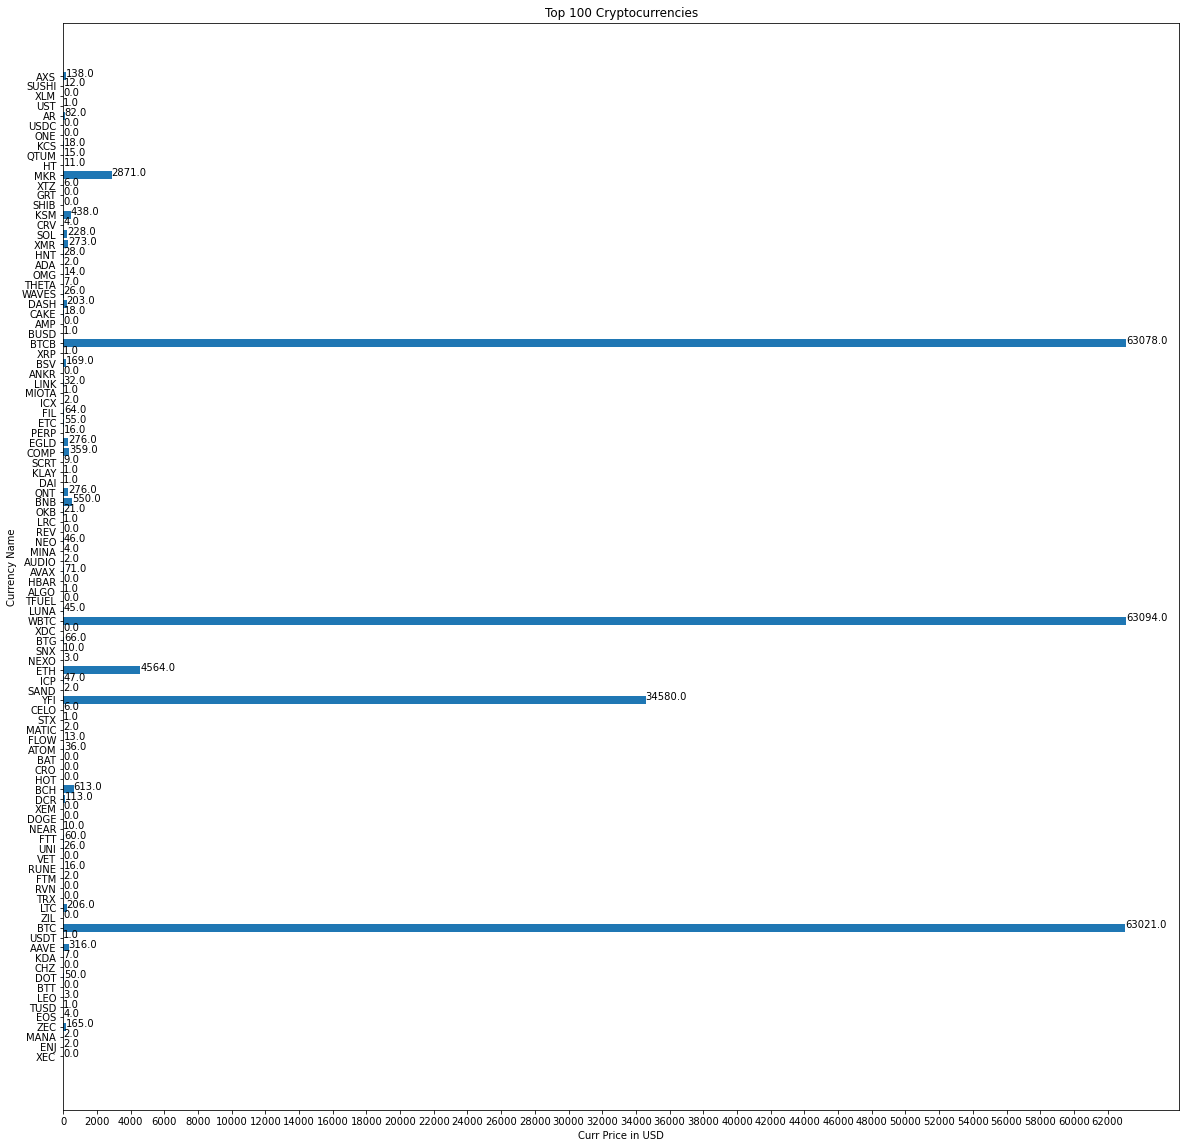

In [10]:
maximum = int(max(crypto_top_100_df['curr_price']))
minimum = int(min(crypto_top_100_df['curr_price']))
plt.figure(figsize=(20, 20))
plt.barh(crypto_top_100_df['symbol'], crypto_top_100_df['curr_price'])
for index, value in enumerate(crypto_top_100_df['curr_price']):
    plt.text(value, index, str(value))
plt.xticks([i for i in range(minimum, maximum, 2000)])
plt.title('Top 100 Cryptocurrencies')
plt.ylabel('Currency Name')
plt.xlabel('Curr Price in USD')
plt.show()

In [11]:
# Querying Crypto Historical Info Table
crypto_historical_info_df =  pd.read_sql_query(text(" SELECT crypto_id, currency_name, price_timestamp, price_close, price_high,\
                                                 price_low, price_open, volume FROM crypto_historical_info_fact_table \
                                                WHERE currency_name = 'ethusd' LIMIT 100"), engine)
crypto_historical_info_df.head(10)

,crypto_id,currency_name,price_timestamp,price_close,price_high,price_low,price_open,volume
0,3205,ethusd,2016-03-12 12:44:00,13.0,13.0,13.0,13.0,3.0
1,3269,ethusd,2016-03-14 09:22:00,13.0,13.0,13.0,13.0,3.0
2,3333,ethusd,2016-03-14 13:26:00,14.0,14.0,14.0,14.0,26.0
3,3397,ethusd,2016-03-14 15:58:00,13.0,13.0,13.0,13.0,61.0
4,3461,ethusd,2016-03-14 18:54:00,14.0,14.0,14.0,14.0,6.0
5,3525,ethusd,2016-03-14 21:52:00,13.0,13.0,13.0,13.0,36.0
6,3589,ethusd,2016-03-14 23:23:00,12.0,12.0,12.0,12.0,16.0
7,3653,ethusd,2016-03-15 02:36:00,12.0,12.0,12.0,12.0,13.0
8,3717,ethusd,2016-03-15 05:44:00,12.0,12.0,12.0,12.0,1.0
9,3781,ethusd,2016-03-15 09:03:00,12.0,12.0,12.0,12.0,20.0


In [12]:
# Querying Crypto Price Timestamp table
crypto_price_timestamp_df = pd.read_sql_query(text("SELECT price_timestamp, day, hours, month, week, weekday, year FROM \
                                                   crypto_price_timestamp LIMIT 100"), engine)
crypto_price_timestamp_df.head(10)

,price_timestamp,day,hours,month,week,weekday,year
0,2017-07-17 05:24:00,17,5,7,29,1,2017
1,2017-07-18 15:51:00,18,15,7,29,2,2017
2,2013-08-04 12:54:00,4,12,8,31,0,2013
3,2017-07-20 02:19:00,20,2,7,29,4,2017
4,2017-07-20 07:35:00,20,7,7,29,4,2017
5,2016-03-17 01:37:00,17,1,3,11,4,2016
6,2016-03-18 10:27:00,18,10,3,11,5,2016
7,2013-08-29 12:53:00,29,12,8,35,4,2013
8,2013-09-30 18:25:00,30,18,9,40,1,2013
9,2017-07-21 22:20:00,21,22,7,29,5,2017


In [13]:
# Querying Bitcoin Historical Price table
bitcoin_historical_price_df = pd.read_sql_query(text("SELECT currency_name, price_timestamp, price_close, price_high,\
                                                 price_low, price_open, volume FROM bitcoin_historical_price \
                                                WHERE price_timestamp > '2019-01-01 00:00:00'"), engine)
bitcoin_historical_price_df.head(10)

,currency_name,price_timestamp,price_close,price_high,price_low,price_open,volume
0,btcusd,2019-01-01 04:50:00,3829.0,3830.0,3829.0,3830.0,1.0
1,btcusd,2019-01-02 17:03:00,4003.0,4004.0,3999.0,3999.0,29.0
2,btcusd,2019-01-03 00:39:00,4036.0,4037.0,4036.0,4037.0,0.0
3,btcusd,2019-01-04 02:10:00,3919.0,3919.0,3919.0,3919.0,2.0
4,btcusd,2019-01-04 02:42:00,3919.0,3919.0,3917.0,3917.0,0.0
5,btcusd,2019-01-04 14:53:00,3877.0,3877.0,3874.0,3874.0,12.0
6,btcusd,2019-01-04 21:05:00,3922.0,3922.0,3921.0,3921.0,0.0
7,btcusd,2019-01-04 22:41:00,3954.0,3954.0,3949.0,3949.0,1.0
8,btcusd,2019-01-05 00:29:00,3989.0,3991.0,3987.0,3987.0,2.0
9,btcusd,2019-01-05 07:44:00,3963.0,3963.0,3963.0,3963.0,1.0


In [14]:
# Querying Crypto Tweet Fact Table
crypto_tweet_df = pd.read_sql_query(text("SELECT * FROM crypto_tweet_fact_table LIMIT 10"), engine)
crypto_tweet_df.head(10)

,tweet_id,tweet_user_id,name,nickname,user_location,followers_count,tweets_count,user_join_date,is_verified,text,likes,retweets,tweet_date,tweet_location,source,sentiment,search_term
0,1454211537384652802,1266195126147330049,olaqueen1212,olaqueen1212,,195,1005,2020-05-29 02:31:44,False,@bitconner hello great investor and traders......,0,0,2021-10-29 22:20:23,None,Twitter Web App,POSITIVE,Crypto Currency Investor
1,1454576606161293313,909515503881908225,Joel Moran,joelvmoran,,530,16575,2017-09-17 20:32:48,False,Crypto is a great thing for countries who rely...,1,0,2021-10-30 22:31:02,None,Twitter for iPhone,POSITIVE,Crypto Currency Investment
2,1453179895287271425,282441884,Crypto Business,kanaba007,Nouvelle calédonie,2996,10613,2011-04-15 06:40:32,False,Crypto-Currency is Here to Stay - Investor's B...,0,0,2021-10-27 02:01:00,None,Buffer,NEUTRAL,Crypto Currency Investor
3,1454389405599289344,2362762537,Topinfo,TopTradersADVFN,,12876,64043,2014-02-26 14:24:48,False,Hold my hands up. I never changed with the wor...,18,0,2021-10-30 10:07:10,None,Twitter for iPhone,NEUTRAL,Crypto Currency Investor
4,1454732672786440197,955756453,Paolo Mipalu,PMipalu,,21,4278,2012-11-18 16:07:43,False,"RT @CNBC: ""I think it's undeniable that bitcoi...",0,128,2021-10-31 08:51:11,None,Twitter for Android,POSITIVE,Crypto Currency Investment
5,1453717813542076418,1532467784,Carl Hayden STOCK PICKER OF THE HIGHEST ORDER !,carlhayden5,green valley,153,1422,2013-06-20 01:17:15,False,$PLFF Orpheum Property \nFirst domestic oil ba...,0,0,2021-10-28 13:38:30,None,Twitter Web App,NEUTRAL,Crypto Currency Investor
6,1454482707812061186,992943418052460544,Ricardo Vázquez,ricardo_ik_ahau,Benito Juárez,1596,389241,2018-05-06 01:45:33,False,RT @jerinkristian: This Token an excellent pro...,0,1,2021-10-30 16:17:55,None,Twitter Web App,POSITIVE,Crypto Currency Investment
7,1454789145788751878,1308982467370549248,lucky 777 🧧,riegoshie,,208,56014,2020-09-24 04:12:07,False,RT @MrCryp21: MrCryp - Crypto Currency Tracker...,0,642,2021-10-31 12:35:35,None,Twitter for iPhone,NEUTRAL,Crypto Currency Tracker
8,1454111511870324740,1172283274745524228,Vaports (1-6),vaports,,566,48116,2019-09-12 22:58:12,False,Meet the young investor interested in crypto c...,10,4,2021-10-29 15:42:55,None,Twitter for Android,NEUTRAL,Crypto Currency Investor
9,1454534432208015362,1453874288298242049,Thomas Richard,ThomasR00627031,,2,5,2021-10-29 00:00:59,False,"Make more than $10,000 weekly on forex trade, ...",1,0,2021-10-30 19:43:27,None,Twitter for Android,NEUTRAL,Crypto Currency Investor


In [15]:
# Querying Crypto Tweet users Table
crypto_tweet_users_df = pd.read_sql_query(text("SELECT * FROM crypto_tweet_users LIMIT 10"), engine)
crypto_tweet_users_df.head(10)

,tweet_user_id,name,nickname,user_location,followers_count,tweets_count,user_join_date,is_verified,source
0,1285675811748683778,sodesu ∞,sodesu_trades,"OTC, pennies, bottom plays",476,4851,2020-07-21 20:39:42,False,Twitter Web App
1,1081620007371661312,seemva,seemva1,"Virginia, USA",59717,73730,2019-01-05 18:34:40,False,Twitter Web App
2,1170872049146851329,justin- mp3chat *i dont actually like nfts,ftp1212,sagittarius sun gemini moon,719,68933,2019-09-09 01:30:36,False,Twitter Web App
3,24911207,BOCVIP,bocvip,,1436,37898,2009-03-17 16:51:37,False,boc.vip
4,1449913808873418761,mari 🍃 $$$,luvenniki_,BIG WINS!!!!,160,13574,2021-10-18 01:43:03,False,Twitter for Android
5,282441884,Crypto Business,kanaba007,Nouvelle calédonie,2996,10613,2011-04-15 06:40:32,False,Buffer
6,771810098025037824,Techmeme Chatter,TechmemeChatter,"San Francisco, CA",2880,192374,2016-09-02 20:40:42,False,Techmeme Editors
7,896038173947469824,"Commerce CPA, LLC",CommerceCPA,"New York, NY",55,676,2017-08-11 15:58:43,False,Cloud Campaign
8,64869841,Investor_NICK,Investor_NICK_,"Minneapolis, MN",4605,4771,2009-08-11 23:58:59,False,Twitter for iPhone
9,1267646587049836544,Lookin4Beans,Lookin4Beans,made you look,284,17474,2020-06-02 02:37:59,False,Twitter for iPhone


In [16]:
# Querying Crypto Tweet users Table
crypto_user_sentiment_df = pd.read_sql_query(text("SELECT * FROM user_sentiment"), engine)
crypto_user_sentiment_df.head(10)

,tweet_user_id,name,user_location,followers_count,tweets_count,tweet_date,tweet_location,sentiment,search_term
0,486475893,Optionbit,,1128,4987,2021-10-28 03:41:58,None,NEUTRAL,Crypto Currency Investor
1,1401671218105925632,Geza❤️CAMEROON,,144,4034,2021-10-25 15:14:42,None,NEGATIVE,Crypto Currency Investor
2,1363658331907190787,Ed209,Ireland,35,305,2021-10-31 07:09:17,None,POSITIVE,Crypto Currency Investment
3,1155891586670088193,airis ☆ Big Win,,75,13698,2021-10-31 12:36:50,None,NEUTRAL,Crypto Currency Tracker
4,1532467784,Carl Hayden STOCK PICKER OF THE HIGHEST ORDER !,green valley,153,1422,2021-10-28 13:38:30,None,NEUTRAL,Crypto Currency Investor
5,55614136,Bobbie,Gaia,126,29346,2021-10-30 02:40:40,None,NEUTRAL,Crypto Currency Investor
6,735199430027120642,AWordFrom Mr.Jones,"Baltimore, MD",455,142,2021-10-26 19:17:31,None,NEUTRAL,Crypto Currency Investor
7,2455958012,satish kumar,"Hisar, India",6,391,2021-10-28 13:09:27,None,POSITIVE,Crypto Currency Investor
8,4487468175,Globalbizdynamics,"London, England.",803,176238,2021-10-30 01:13:38,None,NEUTRAL,Crypto Currency Investor
9,1378539332731031558,Derrick Howell,,21,3620,2021-10-30 02:08:05,None,NEUTRAL,Crypto Currency Investor
